# Exploratory Data Analysis - Assignment 9

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

In [3]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

In [4]:
all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)

In [5]:
df_dow = pd.DataFrame(X_dow, columns = df.columns[1:-5])

## 1. Meaning of Correlation Matrix

**Create the correlation matrix for the first 4 features in the `df_dow`(`x1` through `x4`).**  

The size of the correlation matrix should be 4x4.

In [6]:
first_4 = df_dow[df_dow.columns[0:4]]
corr = first_4.corr()

# another way using np.corrcoef
# corr = np.corrcoef(first_4.values.T)

**Plot `corr` using `seaborn.heatmap`.**

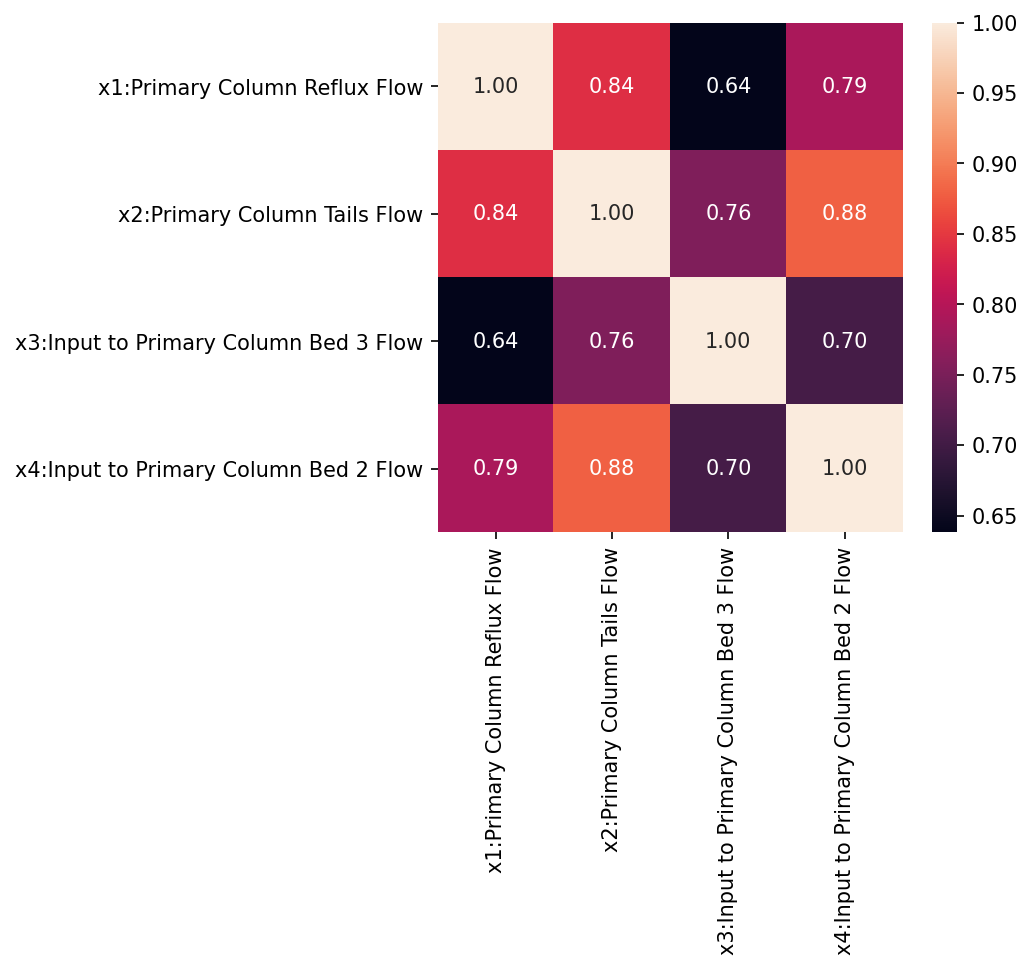

In [7]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
sns.heatmap(corr, annot = True, ax = ax, fmt = '.2f');

**Standardize the first 4 features.**

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(first_4)

**Show that the correlation is numerically equivalent to the regression slope between standardized features.**  
- Use `x2` and `x4` and train a linear regression model with `LinearRegression(fit_intercept = False)`
- Get the slope of the regression
- Compare the correlation and the slope using `numpy.isclose`.

In [9]:
# Get the correlation

corr_2_4 = corr.values[1][3]

# Get the slope
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = False)
lr.fit(X_scaled[:, 1].reshape(-1, 1), X_scaled[:, 3].reshape(-1, 1))
slope = lr.coef_[0][0]

print('Is the correlation equivalent to the regression slope? : {}'.format(np.isclose(corr_2_4, slope)))

Is the correlation equivalent to the regression slope? : True


**Show that the square-value of correlation is numerically equivalent to the $r^2$ score between features.**  
- Use `x1` and `x3` and train a linear regression model with `LinearRegression(fit_intercept = False)`.
- Get the $r^2$ score
- Compare the square-value of correlation and the $r^2$ using `numpy.isclose`.

In [10]:
# Get the r2
lr = LinearRegression(fit_intercept = False)
lr.fit(X_scaled[:, 0].reshape(-1, 1), X_scaled[:, 2].reshape(-1, 1))
r2 = lr.score(X_scaled[:, 0].reshape(-1, 1), X_scaled[:, 2].reshape(-1, 1))

# Get the square-value of correlation
square_corr = corr.values[0][2]**2

print('Is the square-value of correlation equivalent to the r2? {}'.format(np.isclose(square_corr, r2)))

Is the square-value of correlation equivalent to the r2? True


## 2. Low-dimensional Representation

**Load the MNIST data.**

In [11]:
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


**Project the MNIST data onto 10 dimensions using principal component analysis.**  

You may use the `PCA` in scikit-learn or obtain the projection matrix by eigendecomposition.

In [12]:
from sklearn.decomposition import PCA
from numpy.linalg import eig

pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X_mnist)

**Select the points labeled as 8 in the projected data.**

In [13]:
points_8 = X_pca[y_mnist == 8]

**Take the average of those points.**

In [14]:
average_8 = points_8.mean(axis = 0)

**Project the resulting average vector back to the 64-D space.**

In [15]:
reconstructed_8 = pca.inverse_transform(average_8).reshape(1, -1)

**Visualize the reconstructed vector as an 8x8 image.**

In [16]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    colormap = ax.imshow(img, cmap='binary', vmin=0, vmax=16) # vmin and vmax correspond to the minimum and maximum value of the colormap, respectively
    fig.colorbar(colormap, ax=ax)

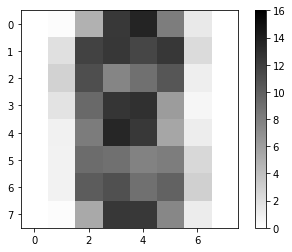

In [17]:
show_image(reconstructed_8, 0)

## 3. Rank of Covariance Matrix

**Get the covariance matrix of the MNIST dataset.**

In [18]:
cov = np.cov(X_mnist.T)

**Compute the rank of this covariance matrix.**

In [19]:
from numpy.linalg import matrix_rank

rank = matrix_rank(cov)
print('Rank of the covariance matrix: {}'.format(rank))

Rank of the covariance matrix: 61


**Compute the eigenvalues.**
- Sort the eigenvalues in a decreasing order.
- Plot the eigenvalues vs. indices.

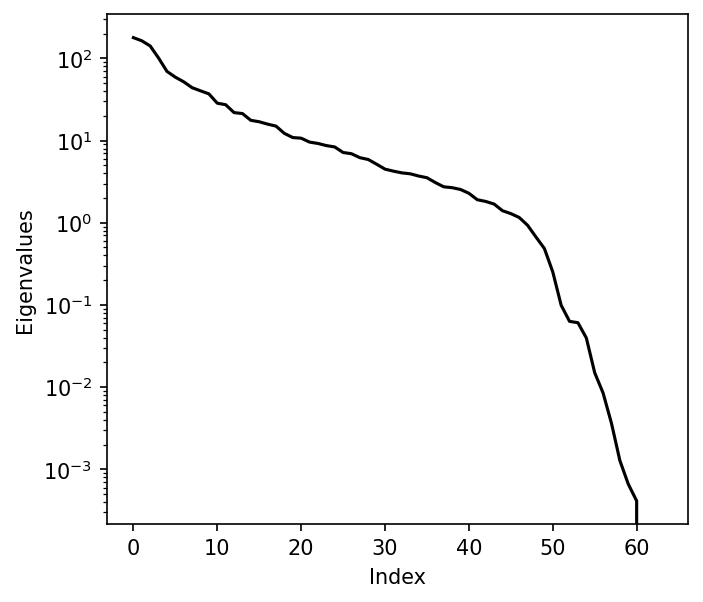

In [20]:
eig_vals, eig_vecs = eig(cov)

sorted_idxs = np.argsort(eig_vals) #this gives us the list of indices from smallest to largest
sorted_idxs = list(sorted_idxs)
sorted_idxs.reverse()
eig_vals = eig_vals[sorted_idxs]

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.plot(sorted_idxs, eig_vals, '-k')
ax.set_xlabel('Index')
ax.set_ylabel('Eigenvalues')
ax.set_yscale('log');

**Find the number of non-zero eigenvalues.**

In [21]:
zero_eig = eig_vals[np.isclose(eig_vals, 0)]
num_zero_eig = zero_eig.shape[0]

print('# of non-zero eigenvalues: {}'.format(64 - num_zero_eig))

# of non-zero eigenvalues: 61


**Briefly describe why an eigenvalue would be zero in terms of the pixels of the original dataset**

> Zero eigenvalues, or a rank-deficient matrix, indicate that there are linearly **dependent** features in a given matrix. In this problem, we use pixel intensities as features. Looking at the summary statistics in the topic notes of topic 1, you may notice that some pixels at corners and edges are just white (pixel intensity = 0) throughout the dataset. These pixels will result in a linearly dependent pair of features in the matrix. Therefore, the rank will decrease and we will have eigenvalues of 0.